# 핵심 용어

## IOU

- 실측값(Ground Truth)과 모델이 예측한 값이 얼마나 겹치는지 나타내는 지표
- IOU가 높을수록 잘 예측한 모델

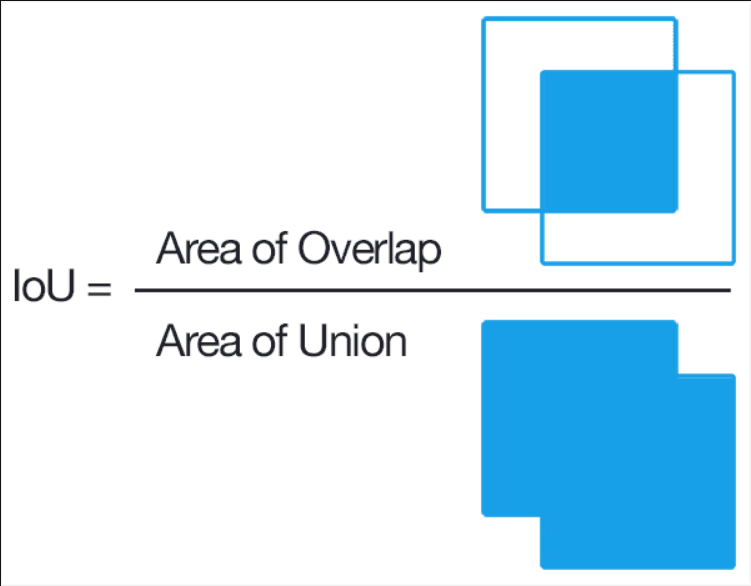

In [ ]:
import numpy as np

# IOU = Intersection / (A + B - Intersection)
def compute_iou(pred_box, gt_box):
  x1 = np.maximum(pred_box[0], gt_box[0])
  y1 = np.maximum(pred_box[1], gt_box[1])
  x2 = np.maximum(pred_box[2], gt_box[2])
  y2 = np.maximum(pred_box[3], gt_box[3])

  # w = np.maximum(x2 - x1, 0), h = np.maximum(y2 - y1, 0)
  intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

  pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
  gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

  union = pred_box_area + gt_box_area - intersection_area

  iou = intersection / union

  return iou

## NMS (Non-Maximum Suppression, 비최댓값 억제)

- 확률이 가장 높은 상자와 겹치는 상자들을 제거하는 과정
- 최댓값을 갖지 않는 상자들을 제거
- 과정
  1. 확률 기준으로 모든 상자를 정렬하고 먼저 가장 확률이 높은 상자를 취함
  2. 각 상자에 대해 다른 모든 상자와의 IOU를 계산
  3. 특정 임계값이 넘는 상자는 제거

In [ ]:
def non_max_suppression_fast(boxes, overlap_thresh):
  if len(boxes == 0):
    return []
  
  # 계산을 위해 box의 좌표값들을 float로 변환
  if boxes.dtype.kind == 'i':
    boxes = boxes.astype('float')
  
  # 박스의 각 꼭지점 좌표 추출
  pick = []
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]

  # 박스들의 넓이를 계산
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  # np.argsort() : 각 값들의 크기를 랭킹으로 반환(작은것부터 0) ex) [1.5, 0.2, 4.2, 2.5] -> [1, 0, 3, 2]
  # y2의 크기 기준 인덱스 생성 (가장 확률이 높은 박스를 취함)
  idxs = np.argsort(y2)


  while len(idxs) > 0:
    # y2 값이 큰 순서(idxs 기준 뒤부터)로 pick에 추가
    last =  len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # 각 박스들과 y2가 가장 큰 박스간 겹치는 영역의 꼭지점 좌표 추출
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.maximum(x2[i], x2[idxs[:last]])
    yy2 = np.maximum(y2[i], y2[idxs[:last]])

    # 공통영역의 높이와 너비 추출
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # 공통영역과 가장 큰 영역간 비율(결과적으로 확률이 됨) 계산
    overlap = (w * h) / area[idxs[:last]]

    # np.delete(배열, 배열에서 삭제할 값) : 배열에서 특정 값을 삭제
    # np.concatenate : 배열 합치기
    # np.where : 배열 내에서 조건에 맞는 값들의 인덱스를 추출
    idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    return boxes[pick].astype('int')

## AP(Average Precision, 평균 정밀도)와 mAP(mean Aberage Precision)

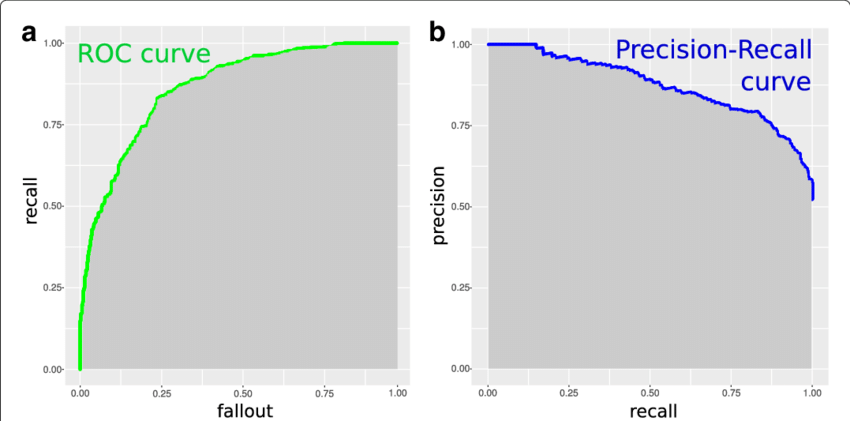

- AP
  - 위 곡선의 아래 영역에 해당
  - 항상 1x1 정사각형으로 구성되어 있음
    - 즉, 항상 0 ~ 1 사이의 값을 가짐
  - 단일 클래스에 대한 모델 성능 정보를 제공

- mAP
  - mAP는 전역 점수를 얻기 위해 사용
  - ex) 데이터셋이 10개의 클래스로 구성된다면 각 클래스에 대한 AP를 계산하고, 그 숫자들의 평균을 다시 구함

## Skip connection - Residual block

- 신경망 모델 학습시 모델의 층이 긾어질 수록 학습 결과가 좋은 것이 일반적
- 그러나 층을 너무 깊게 쌓으면 Vanishing & Exploding Gradient 문제가 발생

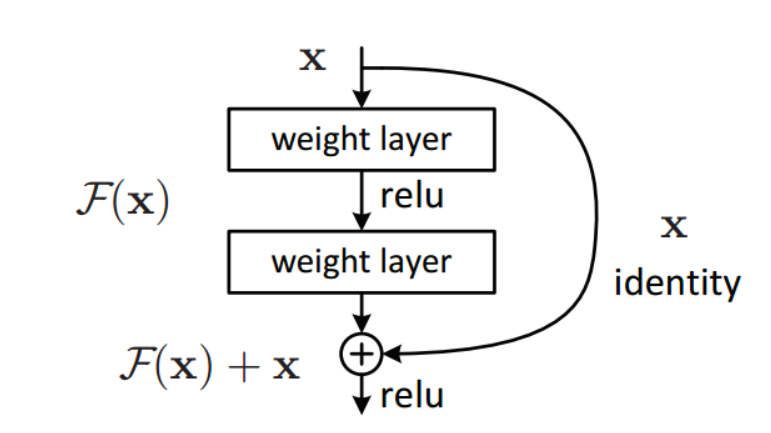

- Skip connection은 이를 해결하기 위해 적용
  - '이전 층의 정보를 이용하기 위해 이전 층의 정보를 연결한다'는 개념

- 이 때, 레이어와 Skip Connection이 있는 블럭을 Residual Block이라고 한다
  - Skip Connection을 적용하면 레이어를 더 깊게 쌇을 수 있으며, 이를 적용한 모델의 경우 error가 이상적으로 줄어드는 것을 확인할 수 있다.

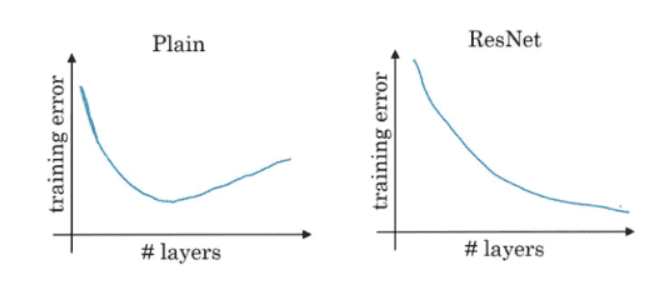

### Upsampling

- Pooling 레이어를 거치면서 축소된 피처맵을 원본 이미지의 크기로 되돌리기 위해서 사용하는 방식
  - Pooling과 반대되는 과정이라서 Unpooling이라고도 불림
  - Conv와 Pooling을 통과시키면서 원본 이미지를 압축해 나가는 과정을 DownSampling이라고 한다면 그 반대로 크기를 늘려나가는 방식을 Upsampling이라고 부름

# YOLO (You Only Look Once) 기본


- 가장 빠른 객체 검출 알고리즘 중 하나
- 작은 크기의 물체를 탐지하는 것은 어려움
---

- YOLO는 오로지 Convolutional layer만을 이용하여, 완벽한 Fully Convolutional Network라고 할 수 있다(FCN).
  - 어떠한 종류의 Pooling도 사용되지 않음
- 기본적으로 75개의 Convolutional layer를 가지고, Skip connection과 upsampling layer들을 가진다
  - stride 2의 값을 가지는 Convolutional layer가 feature map을 downsample

- YOLO는 FCN이기에 입력된 이미지의 사이즈에 영향을 받지 않는다


## YOLO Backbone

- 백본 모델(backbone model) 기반
- 특징 추출기(Feature Extractor)라고도 불림
- YOLO는 자체 맞춤 아키텍쳐 사용
- 어떤 특징 추출기 아키텍쳐를 사용했는지에 다라 성능 달라짐
  - YOLO v5는 CSPNet기반의 CSP-Darknet을 사용
  - CSPNet : CNN의 학습 능력을 향상시킬 수 있는 Backbone으로 DenseNet에 CSP기법을 적용시켜 정확도를 유지시키면서 연산량을 줄여 경량화를 유지
  - ImageNet과 MS COCO같은 컴퓨터 비전의 대표적이 데이터에서 성능 향상

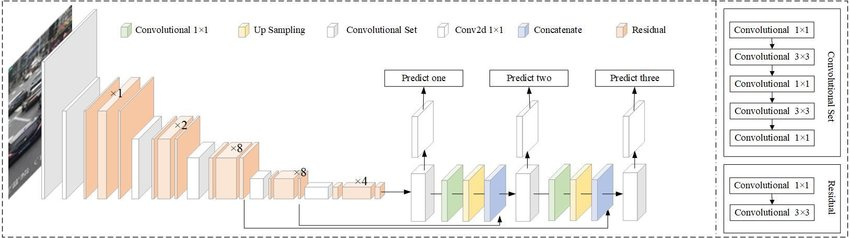

- 마지막 계층은 크기가 w x h x D인 특징 볼륨 출력
- w x h는 그리드의 크기, D는 특징 볼륨 깊이

## YOLO의 계층 출력


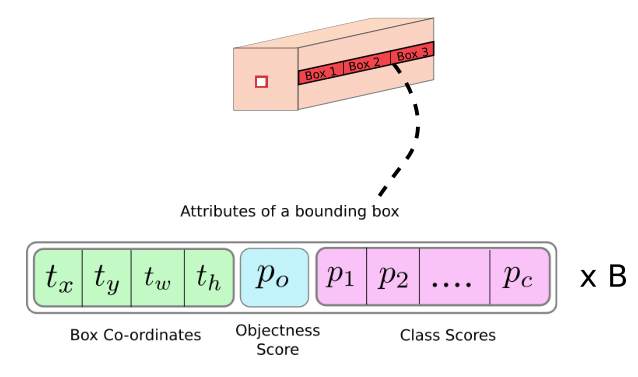

- 마지막 계층 출력은 w x h x M 행렬
  - M = B x (C+5)
    - B : 그리드 셀당 경계 상자 개수
    - C : 클래스 개수
  - 클래스 개수에 5를 더한 이유는 해당 값만큼의 숫자를 예측해야함
    - tx, ty는 경계 상자의 중심 좌표를 계산
    - tw, th는 경계 상자의 너비와 높이를 꼐산
    - c는 객체가 경계 상자 안에 있다고 확신하는 신뢰도
    - p1, p2, ..., pC는 경계상자가 클래스 1, 2, ..., C의 객체를 포함할 확률

## 앵커 박스 (Anchor Box)

- YOLO v2에서 도입
- 사전 정의된 상자(prior box) : 이미지에서 다양한 형태의 Object를 Detection하기 위한 미리 정해진 크기와 비율을 가진 Bounding Box
- 객체에 가장 근접한 앵커박스를 맞추고 신경망을 사용해 앵커 박스의 크기를 조정하는 과정때문에 tx, ty, tw, th이 필요

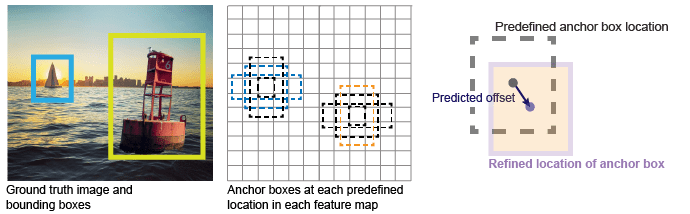

# YOLO v3

## Bounding Box Prediction

1. 이미지를 S * S개의 grid cell로 분할
2. 각 cell 마다 하나의 객체 예측
3. Bounding Box를 통해 객체 위치 및 크기를 파악

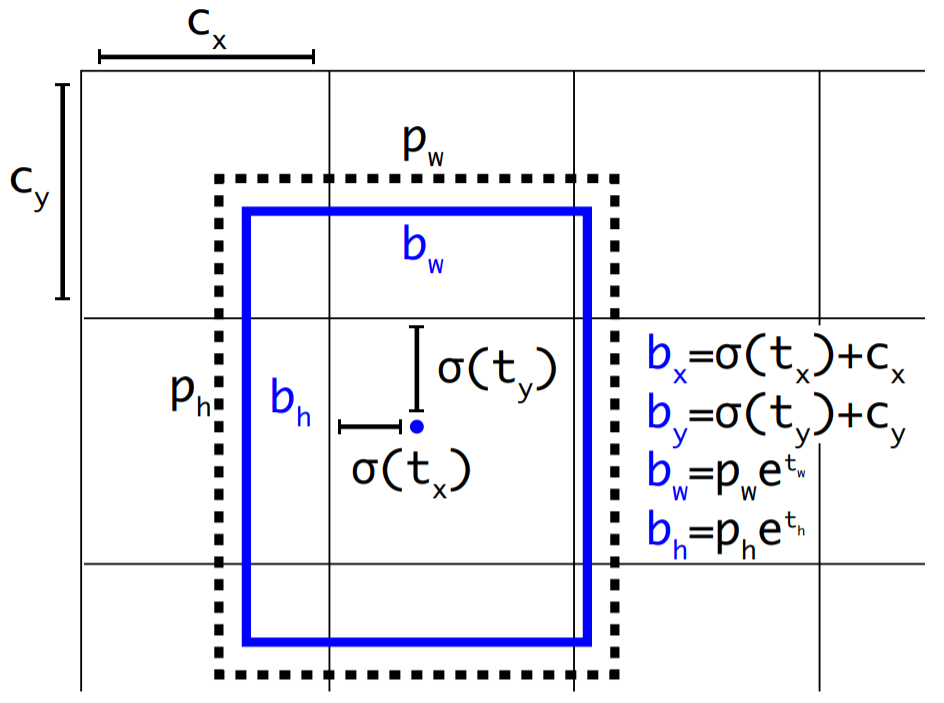

- YOLO v2는 bounding box를 예측할 때 tx, ty, tw, th를 구한 후 위의 그림과 같이 bx, by, bw, bh로 변형한 후 L2 loss(= MSE)를 통해 학습
  - cx, cy는 grid cell의 좌상단 offset
---

- YOLO v3는 ground truth 좌표에 위의 공식을 거꾸로 적용시켜 tx로 변형시킨 후  tx와 직접 L1 loss(= MAE)를 통해 학습
  - ground truth : 우리가 정한 정답 = annotation된 박스

- 예측한 Bounding Box마다 objectness score를 logistic 함수를 적용하여 구함

- Anchor Box와 Ground truth box와의 IoU 값이 가장 높은 box만 매칭

- Ground truth box에 할당되지 못한 bounding box는 Bounding box regression loss를 유발하지 않고, 오직 objectness score에 대한 loss만 발생
  - objectness score : 박스 내에 객체가 있는가에 대한 점수

## Class Prediction

- 각각의 Bounding Box는 Multi-label classification을 수행
- 이 때, softmax 함수로 예측할 경우 성능면에서 좋지 않기 때문에 binary cross-entropy를 사용
  - 하나의 Box 안에 복수의 객체가 존재하는 경우 softmax함수를 사용하면 적절하게 객체를 포착하지 못하는 문제
  - 이런 경우에 binary cross-entropy가 적절

## Prediction across scales

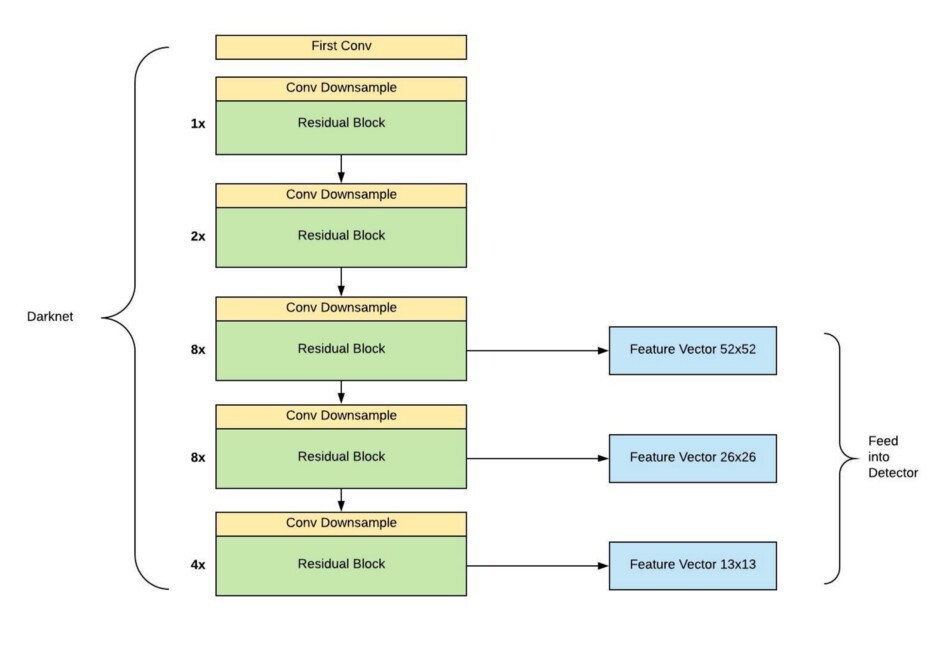

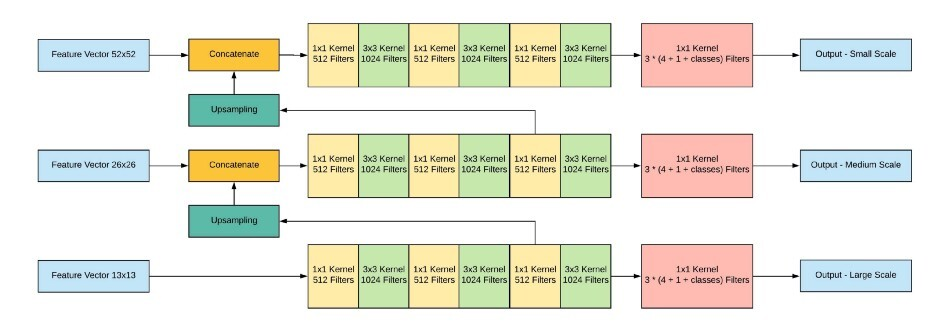

- YOLO v3는 서로 다른 3개의 scale을 사용하여 최종 결과를 예측

1. 416 x 416 크기의 이미지를 입력하여 feature map 크기가 52 x 52, 26 x 26, 13 x 13이 되는 layer에서 feature map을 추출

2. 그 다음 가장 높은 level(해상도가 가장 낮은 feature map)을 1 x 1, 3 x 3 conv layer로 구성된 작은 FCN에 입력

3. FCN의 output channel이 512가 되는 지점에서 feature map을 추출한 뒤 2배로 upsampling 수행

4. 바로 아래 level에 있는 feature map과 concatenate -> 병합된 feature map을 FCN에 입력 -> 이 과정을 다음 level에 있는 feature map에도 똑같이 수행하여 3개의 scale을 가진 feature map을 획득

5. 이 때, 각 scale의 feature map의 output channel 수가 [ 3 x (4 + 1 + classes) ]가 되도록 마지막 1x1 conv later의 channel 수를 조정.
  - 3 : grid cell 당 예측하는 anchor box의 수
  - 4 : bounding box offset
  - 1 : objectness score
  - ex) COCO 데이터셋은 80개의 class로 분류 -> 최종적으로 52x52(x255), 26x26(x255), 13x13(x255) 크기의 feature map을 획득

- 최종적으로 3개의 Scale로 결과가 나오도록 하는 것은 YOLO v3에서 처음 시도되었다
  - v1부터 문제로 인식되던 작은 물체를 잘 감지하지 못하는 것을 해결하기 위해 각 스케일 별로 감지하고자하는 객체의 사이즈가 다르게 지정한다
    - 13 x 13 : 큰 객체 / 26 x 26 : 중간 객체 / 52 x 52 : 작은 객체

## 특징 추출기 (Feature Extractor)

- YOLO v3에서는 shortcut connection이 추가되어 53개의 layer를 가지는 Darknet-53을 backbone network로 사용
- Darknet-53은 ResNet-101보다 1.5배 빠르며, ResNet-152와 비슷한 성능을 보이지만 2배 이상 빠름

## Yolo v3 Training Sequence

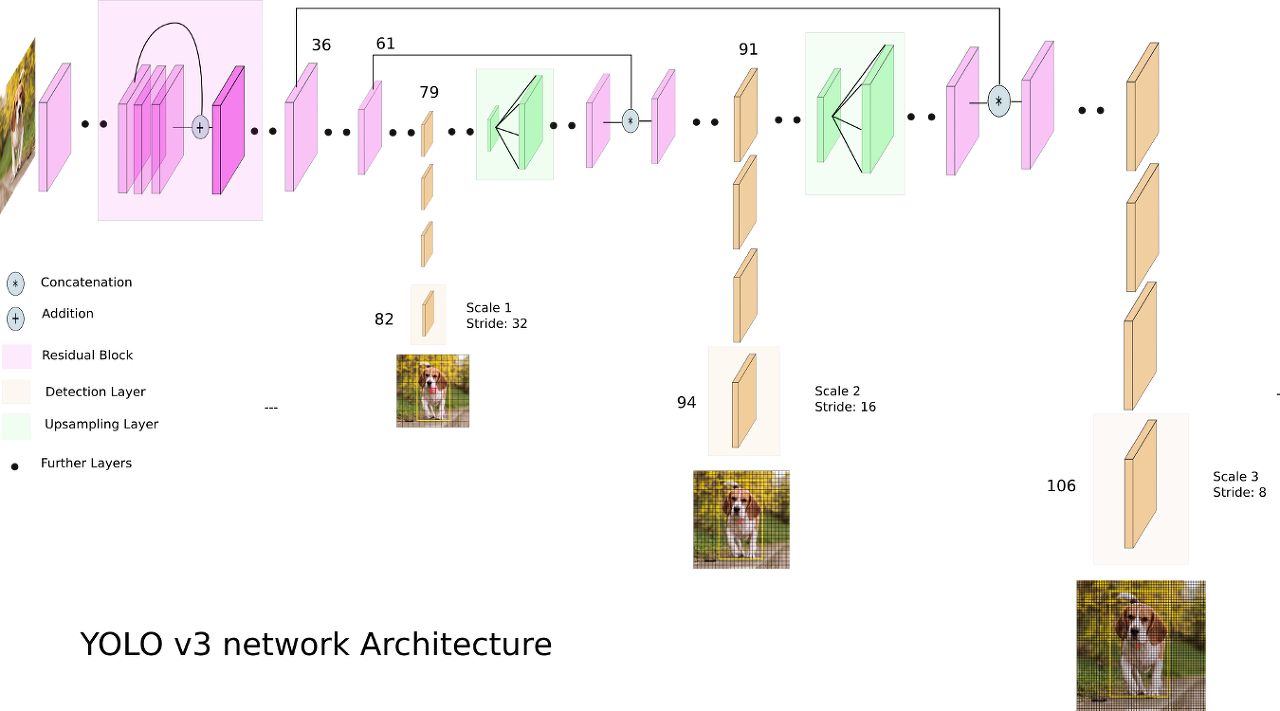

### 1) Feature map by DarkNet-53

- 먼저 이미지를 입력하여 지정한 layer에서 52 x 52, 26 x 26, 13 x 13 크기의 feature map을 추출
  - Input : 416 x 416 sized image
  - Process : extract feature maps
  - Output : 52 x 52, 26 x 26, 13 x 13 sized feature maps

### 2) Building feature pyramid by FCN (Fully Connected Network)

- 앞서 얻은 3개의 서로 다른 scale을 가진 feature map을 1x1, 3x3 conv로 구성된 FCN에 입력하여 feature pyramid를 설계
- **Prediction across scales**에서 설명한 결과가 도출됨

### 3) Train Yolo v3 by loss function

- 앞서 얻은 multi-scale feature maps를 loss function을 통해 학습
- YOLO v3의 loss function은 총 4개의 항으로 구성
  1. bounding box offset의 MSE(Mean Squared Error)
  2. 객체를 예측하도록 할당된 bounding box의 objectness score의 BCE (Binary Cross Entropy)
  3. 객체를 예측하도록 할당되지 않은 bounding box 의 no objectness score의 BCE
  4. bouding box의 multi-class BCE

## Inference

- Inference 시에는 마지막 예측 결과에 NMS(Non Maximum Suppression)을 적용

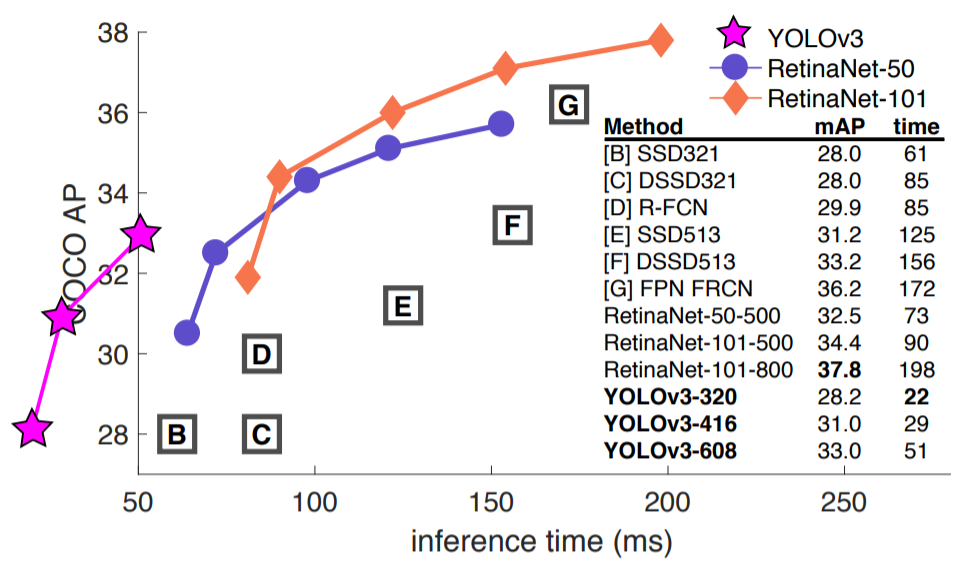

- RetinalNet에 비해서는 다소 낮은 성능을 보이지만, SSD와 성능이 비슷하면서 속도는 3배 빠름
- inference 속도 면에서 혁신적

## Optimizer

- YOLO의 default optimizer는 SGD( 확률적 경사 하강법, Stochastic Gradient Descent )

### SGD ( 확률적 경사 하강법, Stochastic Gradient Descent )

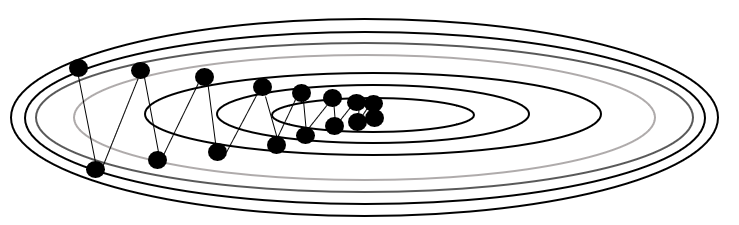

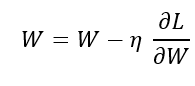

- SGD는 기울기가 가르키는 방향을 탐색
  - 현재 위치에서 기울어진 방향이 전체적인 최솟값과 다른 방향을 가리키므로 지그재그 모양으로 탐색 -> 시간에 비해 학습률의 성장이 낮아진다
- SGD의 단점
  - 비등방성(anisotropy) 함수에서는 탐색경로가 비효율적
    - 비등방성 함수 : 특정 좌표에서 기울기의 성질(기울기가 가르키는 지점)이 변하는 함수
  - 무작정 기울어진 방향으로 나아가는 방식보다 더 효율적인 방식 필요
  - 이를 보완한 기법으로 Momentum, AdaGrad, Adam이 있다

In [ ]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### Momentum

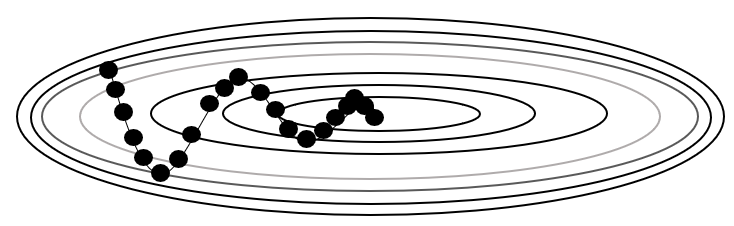

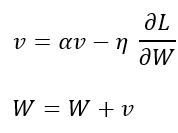

- SGD와 달리 새로운 변수 v가 나오는데, 이는 물리에서 말하는 속도(velocity)이다.
- Momentum은 '운동량'을 뜻하는 단어로 기울기 방향으로 힘을 받아 물체가 가속되어 공이 구르는 듯한 움직임을 보인다. 위의 식에서 알파가 가속도와 관련된 파라미터
- SGD와 최적화 과정을 비교하면 지그재그 정도가 덜하다.
  - x축의 힘은 작지만 방향이 변하지 않으므로 일정하게 가속하여 SGD보다 x축 방향으로 빠르게 나아가기 때문

In [ ]:
class Momentum:
    def __init__(self, ir = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momemtum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
            for key in parmas.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
                params[key] += self.v[key]

### AdaGrad

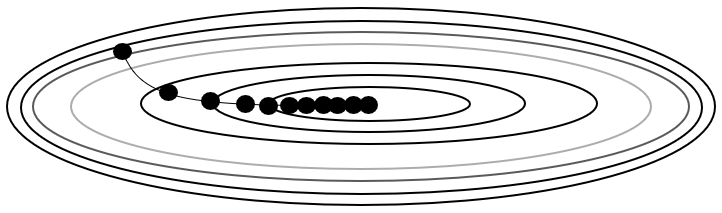

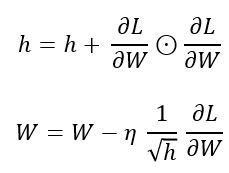

- 신경망 학습에서 학습률을 적절하게 설정하는 것이 중요
  - 이를 위해 학습률 감소(learning rate decay)라는 기술을 사용하는데 이는 학습 진행 중에 학습률을 줄여가는 방법
  - 즉, 처음엔 크게 학습을 하다가 점점 작게 학습

- 위의 방법을 발전시킨 것이 AdaGrad
  - 각 매개변수를 Adaptive하게 조정하여 맞춤형 learning rate를 만든다.

- SGD와 달리 새로운 변수 h가 나오는데 이는 기존의 기울기 값을 제곱한 값을 더하여 학습률을 조정하기 위한 변수(⊙기호는 행렬의 원소별 곱셈을 의미)
  - 매개변수의 원소 중 크게 갱신된 원소는 학습률이 낮아지면 학습률 감소가 매개변수의 원소마다 다르게 적용된다

In [ ]:
class AdaGrad:
  def __init__(self, lr = 0.01):
    self.lr = lr
    self.h = None
  
  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for ket, val in params.items():
        self.h[key] = np.zeros_like(val)

    for key in params.keys():
      self.h[key] += grads[key] * grads[key]
      params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)

### Adam

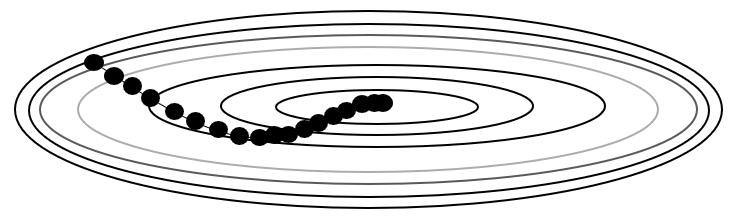

- 공 구르는 듯한 Momentum과 적응적인 AdaGrad를 융합한 기법
- 학습률, 일차 모멘텀용 계수, 이차 모멘텀용 계수로 3개의 하이퍼 파라미터를 설정
  - 일차 모멘텀용 계수 = 0.9, 이차 모멘텀용 계수 = 0.999를 기본 설정값으로 하면 보통 좋은 결과를 얻을 수 있다.

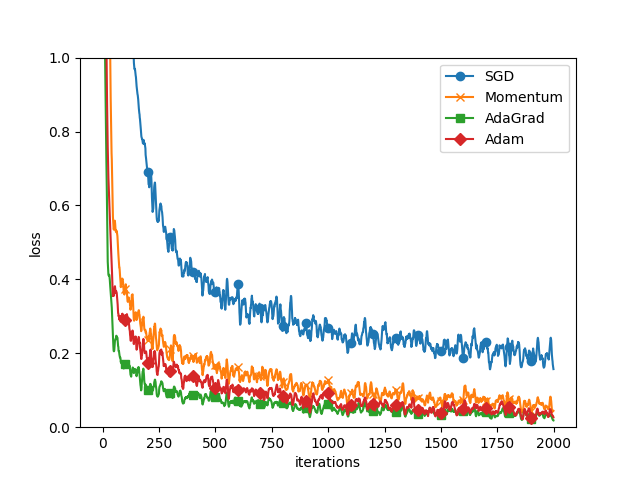

- 학습률과 신경망 구조에 따라 결과가 다르게 나타나지만, 일반적으로 SGD보다 Momentum, AdaGrad, Adam의 최종 정확도가 높게 나온다